In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]
navigation_metrics = [c for c in metrics if c in ['trajectory_length', 'execution_time', 'success_rate', 'collision_rate']]

# add metrics from existing ones
df['mean_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
navigation_metrics += ['mean_velocity', 'collisionless_success_rate']
metrics += ['mean_velocity', 'collisionless_success_rate']
metrics_and_versions += ['mean_velocity', 'collisionless_success_rate']

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    4228

## Run Parameters

    amcl_alpha_factor                                                      [nan, 0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl', 'localization_generator']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    collision_rate                                                         min:          0             avg:    0.09886             max:          1             nan:          0

<code><font style='background-color:yellow;font-family:monospace'>collision_rate_version                                                [1, 2] </font></code> ⚠️

    controller_cpu_time                                                    min:       0.53             avg:      89.14             max:      848.9             nan:          4

    controller_max_memory                                                  min:      21.35             avg:      52.48             max:      78.79             nan:          4

    cpu_time_and_max_memory_version                                        [1]

    execution_time                                                         min:      0.078             avg:      83.18             max:        627             nan:          8

    execution_time_version                                                 [1]

    localization_update_absolute_rotation_error_mean                       min:  3.887e-07             avg:    0.03075             max:      1.831             nan:        593

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04808             max:      1.348             nan:        593

    localization_update_absolute_translation_error_mean                    min:   0.003454             avg:    0.09966             max:      3.029             nan:        593

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.03837             max:      3.775             nan:        593

    localization_update_error_version                                      [1]

    localization_update_normalized_relative_rotation_error_mean            min:   0.001355             avg:     0.2336             max:      12.29             nan:        609

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:       1.05             max:      43.93             nan:        609

    localization_update_normalized_relative_translation_error_mean         min:    0.00843             avg:    0.07566             max:      3.082             nan:        608

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.08458             max:      9.121             nan:        608

    localization_update_rate_mean                                          min:    0.09353             avg:     0.9857             max:       32.4             nan:        586

    localization_update_rate_std                                           min:          0             avg:     0.3398             max:      14.34             nan:        586

    localization_update_rate_version                                       [1]

    localization_update_relative_rotation_error_mean                       min:  2.441e-07             avg:    0.01614             max:     0.8108             nan:        593

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.04571             max:     0.7957             nan:        593

    localization_update_relative_translation_error_mean                    min:  1.036e-05             avg:    0.01422             max:     0.5565             nan:        593

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01354             max:      1.529             nan:        593

    odometry_error_alpha_1_mean                                            min:  1.143e-17             avg:    0.08821             max:      11.76             nan:        603

    odometry_error_alpha_1_std                                             min:          0             avg:     0.1869             max:      44.74             nan:        603

    odometry_error_alpha_2_mean                                            min:  1.522e-18             avg:     0.1253             max:      9.943             nan:        603

    odometry_error_alpha_2_std                                             min:          0             avg:     0.2813             max:       24.4             nan:        603

    odometry_error_alpha_3_mean                                            min:  3.373e-17             avg:    0.06812             max:     0.8971             nan:        603

    odometry_error_alpha_3_std                                             min:          0             avg:    0.02505             max:      1.184             nan:        603

    odometry_error_alpha_4_mean                                            min:  2.374e-17             avg:     0.2619             max:      1.401             nan:        603

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2342             max:      1.326             nan:        603

    odometry_error_version                                                 [2]

    planner_cpu_time                                                       min:       0.32             avg:      27.44             max:        395             nan:          4

    planner_max_memory                                                     min:      22.52             avg:      762.1             max:  3.116e+04             nan:          4

    success_rate                                                           min:          0             avg:     0.7013             max:          1             nan:          0

    success_rate_version                                                   [1]

    system_cpu_time                                                        min:          3             avg:      129.8             max:       1005             nan:          4

    system_max_memory                                                      min:      132.4             avg:      935.9             max:  3.134e+04             nan:          4

    trajectory_length                                                      min:          0             avg:      18.77             max:      128.6             nan:          8

    trajectory_length_version                                              [1]

    mean_velocity                                                          min:          0             avg:     0.1908             max:     0.2681             nan:          8

    collisionless_success_rate                                             min:          0             avg:     0.6561             max:          1             nan:          0

In [6]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[navigation_metrics].agg(['mean', 'count']).sort_values(('collisionless_success_rate', 'mean'), ascending=False)

collision_rate       execution_time       success_rate       trajectory_length       mean_velocity       collisionless_success_rate      
                                                                                       mean count           mean count         mean count              mean count          mean count                       mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                                                                               
turtle      dwb                90.000                 amcl                            0.006   640         82.646   639        0.931   640            20.038   639         0.218   639                      0.925   640
                                                      localization_generator          0.007   148         85.965   148        0.878   148            20.951   148         0.220   148                      0.872   148
            teb                40.000                 amcl                            0.101   377        101.375   375        0.817   377            22.638   375         0.218   375                      0.785   377
                               90.000                 localization_generator          0.066   181         72.992   181        0.790   181            17.722   181         0.226   181                      0.768   181
                               40.000                 localization_generator          0.089   282         89.995   282        0.723   282            20.493   282         0.209   282                      0.702   282
                               20.000                 amcl                            0.078   383        118.257   383        0.687   383            24.646   383         0.199   383                      0.658   383
                                                      localization_generator          0.069   277        100.565   277        0.621   277            20.950   277         0.191   277                      0.592   277
            rpp                90.000                 localization_generator          0.284   109        119.072   109        0.697   109            26.838   109         0.211   109                      0.550   109
            teb                90.000                 amcl                            0.036  1210         45.488  1205        0.560  1210            10.868  1205         0.149  1205                      0.545  1210
            rpp                90.000                 amcl                            0.345   621        109.395   621        0.638   621            23.480   621         0.194   621                      0.457   621

In [7]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
    ax = (bar_df.sort_values(by=('mean'), ascending=True)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', '))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
    plt.show()

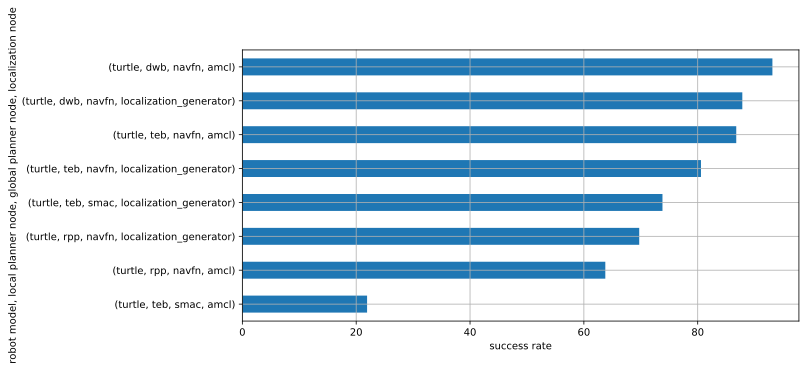

In [8]:
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)

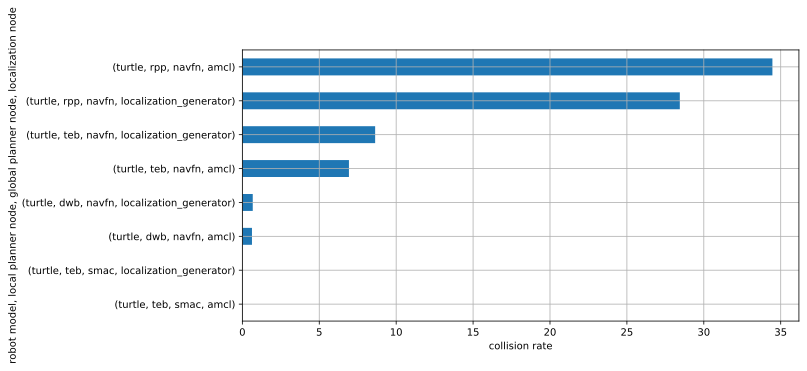

In [9]:
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)

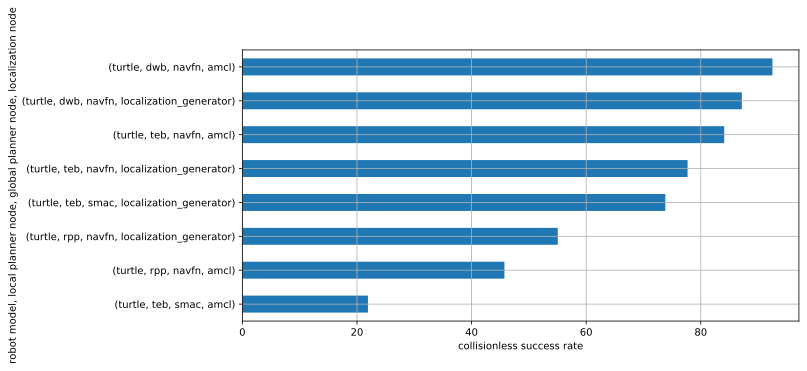

In [10]:
bar_plot(metric_name='collisionless_success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)

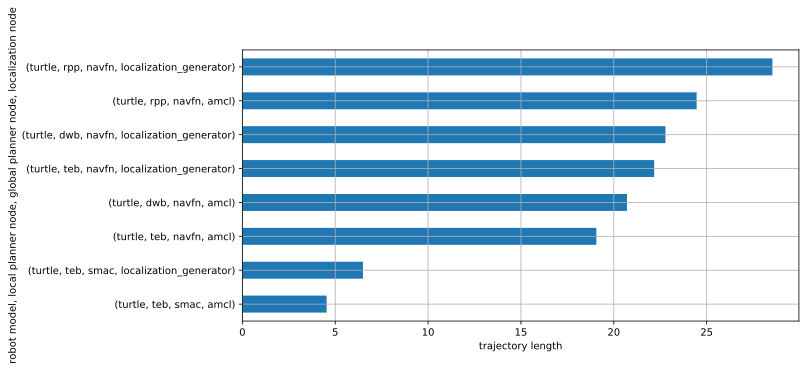

In [11]:
bar_plot(metric_name='trajectory_length', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])

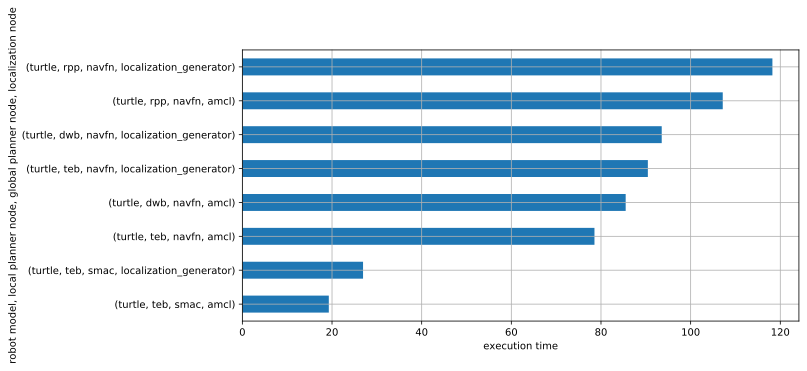

In [12]:
bar_plot(metric_name='execution_time', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])

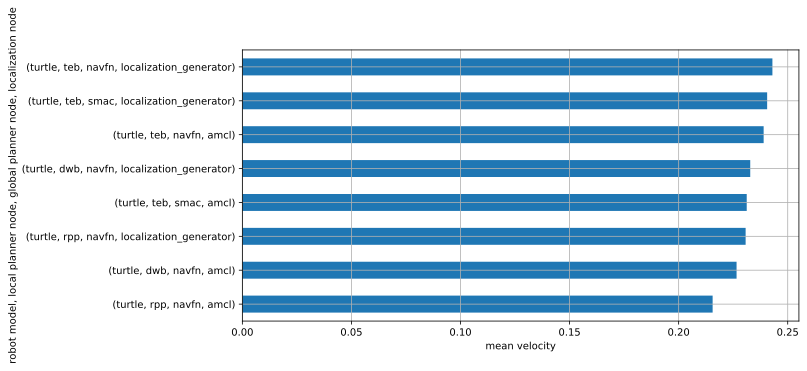

In [13]:
bar_plot(metric_name='mean_velocity', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


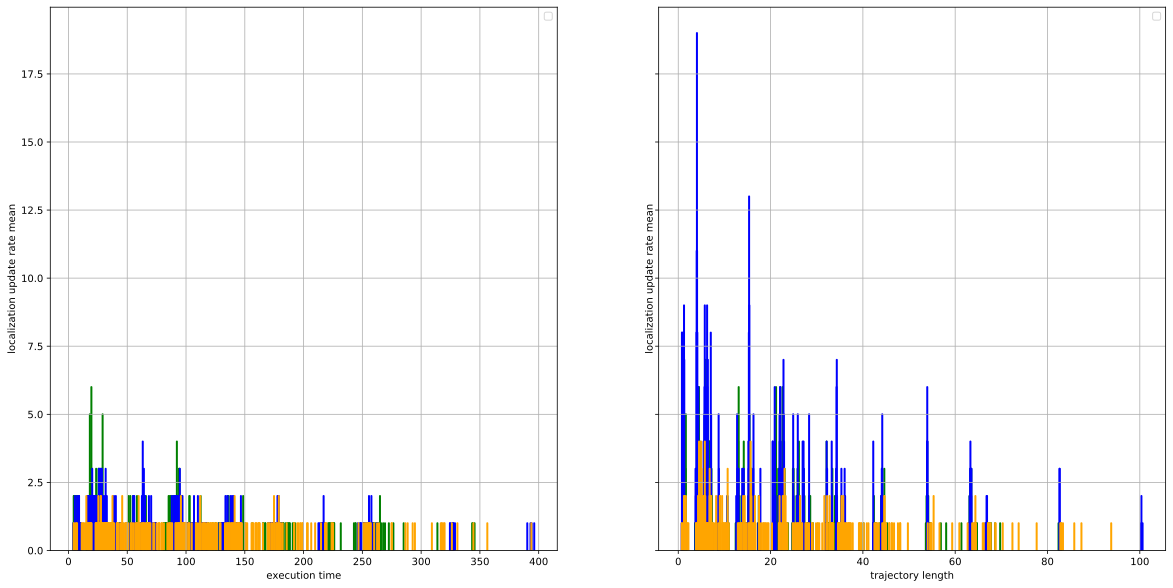

In [15]:
def hist_in_out_metrics(output_metric, input_metrics, bin_widths, selected_df):
    fig, axes = plt.subplots(1, len(input_metrics), sharey=True)
    
    il = len(input_metrics)
    jl = len(df.local_planner_node.unique())
    kl = len(df.localization_node.unique())
    
    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        if bin_width is not None:
            bins = np.arange(0., input_metric.max(), bin_width)
        for j, local_planner_node in enumerate(df.local_planner_node.unique()):
            for k, localization_node in enumerate(df.localization_node.unique()):
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if bin_width is not None:
                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').count()
                    axes[i].bar(df_lr_g.index.values+(j-jl/2)*bin_width/jl/kl/2+(k-kl/2)*bin_width/kl, df_lr_g[output_metric.name], color=local_planner_color[local_planner_node], width=bin_width/jl/kl/2, fill=not g, linewidth=2, edgecolor=local_planner_color[local_planner_node])
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).count()
                    axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], color=local_planner_color[local_planner_node])

        axes[i].legend()
        axes[i].grid()
        axes[i].set_xlabel(input_metric.name.replace('_', ' '))
        axes[i].set_ylabel(output_metric.name.replace('_', ' '))

    fig.set_size_inches([10*len(input_metrics), 10])
    plt.show()


df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle')].copy()
# hist_in_out_metrics(
#     output_metric=df_s.collisionless_success_rate, 
#     input_metrics=[df_s.localization_update_absolute_translation_error_mean, df_s.localization_update_normalized_relative_translation_error_mean, df_s.alpha_1], 
#     bin_widths=[0.05, 0.05, None],
#     selected_df=df_s
# )
# df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.collisionless_success_rate == 1)].copy()
# hist_in_out_metrics(
#     output_metric=df_s.trajectory_length, 
#     input_metrics=[df_s.localization_update_absolute_translation_error_mean, df_s.localization_update_normalized_relative_translation_error_mean, df_s.alpha_1], 
#     bin_widths=[0.05, 0.05, None],
#     selected_df=df_s
# )
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.collisionless_success_rate == 1) & (df.global_planner_node == 'navfn')].copy()
hist_in_out_metrics(
    output_metric=df_s.localization_update_rate_mean, 
    input_metrics=[df_s.execution_time, df_s.trajectory_length], 
    bin_widths=[0.05, 0.05],
    selected_df=df_s
)

In [ ]:
def plot_in_out_metrics_bin_width(output_metric, input_metrics, bin_widths, selected_df):
    fig, axes = plt.subplots(1, len(input_metrics))

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        for local_planner_node in df.local_planner_node.unique():
            for localization_node in df.localization_node.unique():
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if bin_width is not None:
                    if isinstance(bin_width, str):
                        _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                    else:
                        bins = np.arange(0., input_metric.max(), bin_width)
                    
                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').mean()
#                     axes[i].plot(df_lr_g[input_metric.name], df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
                    axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
                        
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).mean()
                    axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])

        axes[i].legend()
        axes[i].grid()
        axes[i].set_xlabel(input_metric.name.replace('_', ' '))
        axes[i].set_ylabel(output_metric.name.replace('_', ' '))
        axes[i].set_ylim([0, output_metric.max()*1.1])

    fig.set_size_inches([10*len(input_metrics), 10])
    plt.show()

df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width(
    output_metric=df_s.collisionless_success_rate, 
    input_metrics=[df_s.localization_update_absolute_translation_error_mean, df_s.localization_update_normalized_relative_translation_error_mean, df_s.alpha_1], 
    bin_widths=[.1, .1, None],
    selected_df=df_s
)

In [1]:
def bin_c_w(l, c_max, w_max):
    c = 0
    w = 0.0
    if len(l) == 0:
        return []
    l = sorted(l)
    bins = list()
    bins.append(l[0])
    for i in l[1:]:
        c += 1
        w = i - bins[-1]
#         print("i", i, "c", c, "w", w, "bins", bins)
        if c >= c_max or w >= w_max:
            bins.append(i)
#             print("i", i, "c", c, "w", w, "bins", bins)
            c = 0
            w = 0.0
            
    return bins
print(bin_c_w(l=[0.0, 0.1, 0.2, 0.3, 1.0, 1.1, 2.0, 3.0], c_max=3, w_max=1.0))

[0.0, 0.3, 2.0, 3.0]


In [ ]:
def plot_in_out_metrics_bin_count_(output_metric, input_metrics, selected_df, bin_widths=None):
    fig, axes = plt.subplots(1, len(input_metrics))

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        for local_planner_node in df.local_planner_node.unique():
            for localization_node in df.localization_node.unique():
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy().sort_values(input_metric.name)
                if bin_width is not None:
                    if len(df_lr[input_metric.name].values) < 1:
                        continue
                    bins = list(df_lr[input_metric.name].values[::bin_width])
                    bins.append(df_lr[input_metric.name].values[-1] + 1.0)
                    
                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').mean()
                    axes[i].plot(df_lr_g[input_metric.name], df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
#                     axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).mean()
                    axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])

        axes[i].legend()
        axes[i].grid()
        axes[i].set_xlabel(input_metric.name.replace('_', ' '))
        axes[i].set_ylabel(output_metric.name.replace('_', ' '))
        axes[i].set_ylim([0, output_metric.max()*1.1])

    fig.set_size_inches([10*len(input_metrics), 10])
    plt.show()


In [ ]:
def plot_in_out_metrics_bin_count_width(output_metric, input_metrics, selected_df, bin_widths=None, bin_counts=None):
    fig, axes = plt.subplots(1, len(input_metrics))
    
    for i, (input_metric, bin_count, bin_width) in enumerate(zip(input_metrics, bin_counts, bin_widths)):
        for local_planner_node in df.local_planner_node.unique():
            for localization_node in df.localization_node.unique():
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy().sort_values(input_metric.name)
                if bin_width is not None:
                    if len(df_lr[input_metric.name].values) < 1:
                        continue
                    bins = bin_c_w(list(df_lr[input_metric.name].values), c_max=bin_count, w_max=bin_width)
                    
                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').mean()
                    axes[i].plot(df_lr_g[input_metric.name], df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
#                     axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).mean()
                    axes[i].plot(df_lr_g.index, df_lr_g[output_metric.name], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node} {localization_node}', linewidth=3 if g else 2, color=local_planner_color[local_planner_node])

        axes[i].legend()
        axes[i].grid()
        axes[i].set_xlabel(input_metric.name.replace('_', ' '))
        axes[i].set_ylabel(output_metric.name.replace('_', ' '))
        axes[i].set_ylim([0, output_metric.max()*1.1])

    fig.set_size_inches([10*len(input_metrics), 10])
    plt.show()

In [ ]:
c = 50
w = 0.2
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn')].copy()
plot_in_out_metrics_bin_count_width(
    output_metric=df_s.collisionless_success_rate, 
    input_metrics=[df.localization_update_absolute_translation_error_mean, df.localization_update_absolute_rotation_error_mean, df.localization_update_normalized_relative_translation_error_mean, df.localization_update_normalized_relative_rotation_error_mean, df.localization_update_rate_mean, df.alpha_1], 
    bin_counts=[c, c, c, c, c, None],
    bin_widths=[w, w, w, 2.0, w, None],
    selected_df=df_s
)

In [ ]:
c = 50
w = 0.2
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_count_width(
    output_metric=df.success_rate, 
    input_metrics=[df.localization_update_absolute_translation_error_mean, df.localization_update_absolute_rotation_error_mean, df.localization_update_normalized_relative_translation_error_mean, df.localization_update_normalized_relative_rotation_error_mean, df.localization_update_rate_mean, df.alpha_1], 
    bin_counts=[c, c, c, c, c, None],
    bin_widths=[w, w, w, 2.0, w, None],
    selected_df=df_s
)

In [ ]:
c = 50
w = 0.2
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_count_width(
    output_metric=df.collision_rate, 
    input_metrics=[df.localization_update_absolute_translation_error_mean, df.localization_update_absolute_rotation_error_mean, df.localization_update_normalized_relative_translation_error_mean, df.localization_update_normalized_relative_rotation_error_mean, df.alpha_1], 
    bin_counts=[c, c, c, c, None],
    bin_widths=[w, w, w, w, None],
    selected_df=df_s
)

In [ ]:
c = 50
w = 0.2
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.collisionless_success_rate == 1) & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_count_width(
    output_metric=df.mean_velocity, 
    input_metrics=[df.localization_update_absolute_translation_error_mean, df.localization_update_absolute_rotation_error_mean, df.localization_update_normalized_relative_translation_error_mean, df.localization_update_normalized_relative_rotation_error_mean, df.alpha_1], 
    bin_counts=[c, c, c, c, None],
    bin_widths=[w, w, w, w, None],
    selected_df=df_s
)

In [ ]:
c = 50
w = 0.2
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.collisionless_success_rate == 1) & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_count_width(
    output_metric=df.execution_time, 
    input_metrics=[df.localization_update_absolute_translation_error_mean, df.localization_update_absolute_rotation_error_mean, df.localization_update_normalized_relative_translation_error_mean, df.localization_update_normalized_relative_rotation_error_mean, df.alpha_1], 
    bin_counts=[c, c, c, c, None],
    bin_widths=[w, w, w, w, None],
    selected_df=df_s
)

In [ ]:
c = 50
w = 0.2
df_s = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.collisionless_success_rate == 1) & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_count_width(
    output_metric=df.trajectory_length, 
    input_metrics=[df.localization_update_absolute_translation_error_mean, df.localization_update_absolute_rotation_error_mean, df.localization_update_normalized_relative_translation_error_mean, df.localization_update_normalized_relative_rotation_error_mean, df.alpha_1], 
    bin_counts=[c, c, c, c, None],
    bin_widths=[w, w, w, w, None],
    selected_df=df_s
)

In [ ]:
df_local_planner_plots_succ = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.collisionless_success_rate == 1) & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
